In [1]:
# main function
import numpy as np
import torch
import matplotlib.pyplot as plt
import botorch

from xopt.bayesian_exploration import bayesian_exploration
from xopt.bayesian.models.nan_enabled import NanEnabledModelListGP

from botorch.models import SingleTaskGP, ModelListGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood


# test function
from xopt.evaluators import test_TNK


In [2]:
"""
    Example where we must use a custom botorch model to make predictions. 
    We modify the test_TNK function with a wrapper to return Nan values for the y1 objective if one of the constraints are not satisfied.
    To accomidate this we define a ModelListGP model as a custom model to remove Nan values from the training data.

"""

# define a new test function that returns nans for y1 if c1 is not valid
def nan_test_TNK(x):
    outputs = test_TNK.evaluate_TNK(x)
    if outputs['c1'] < 0:
        outputs['y1'] = np.nan
        
    return outputs


# Get VOCS
VOCS = test_TNK.VOCS
VOCS['objectives'] = {'y1' : None}

# add reference point
ref = torch.tensor((1.4, 1.4))

print(VOCS)
# Get evaluate function
EVALUATE = nan_test_TNK

# Run
init_x = torch.tensor([[0.9, 0.9], [0.6, 0.6]])
results = bayesian_exploration(VOCS, EVALUATE,
                               custom_model = NanEnabledModelListGP,
                               restart_data_file = 'results.json',
                               n_initial_samples=5,
                               initial_x=None,
                               use_gpu=False,
                               n_steps=2, 
                               verbose=True)

{'name': 'TNK_test', 'description': 'Constrainted test function TNK. See Table V in https://www.iitk.ac.in/kangal/Deb_NSGA-II.pdf', 'simulation': 'test_TNK', 'variables': {'x1': [0, 3.14159], 'x2': [0, 3.14159]}, 'objectives': {'y1': None}, 'constraints': {'c1': ['GREATER_THAN', 0], 'c2': ['LESS_THAN', 0.5]}, 'constants': {'a': 'dummy_constant'}, 'linked_variables': {'x9': 'x1'}}
No executor given. Running in serial mode.
tensor([[1.5010, 0.0000]], dtype=torch.float64)
tensor([[0.4946, 1.0840]], dtype=torch.float64)


['variables', 'objectives', 'constraints', 'constraint_status', 'feasibility', 'model']


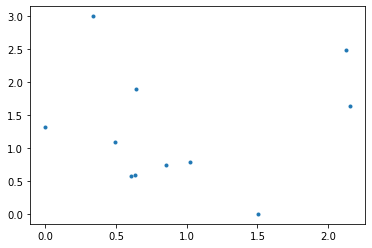

In [3]:
fig, ax = plt.subplots()
print(list(results.keys()))
ax.plot(results['variables'][:, 0], results['variables'][:, 1], '.')

plt.show()